測試參數: {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.9}
F1-score (label=1): 0.2526
測試參數: {'max_depth': 6, 'learning_rate': 0.05, 'n_estimators': 200, 'subsample': 1.0}
F1-score (label=1): 0.2887
測試參數: {'max_depth': 3, 'learning_rate': 0.2, 'n_estimators': 150, 'subsample': 0.8}
F1-score (label=1): 0.2922
最佳模型評估:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18413
           1       0.83      0.18      0.29       327

    accuracy                           0.99     18740
   macro avg       0.91      0.59      0.64     18740
weighted avg       0.98      0.99      0.98     18740

MAE: 0.014994663820704376
MSE: 0.014994663820704376
R^2: 0.1254118259420155


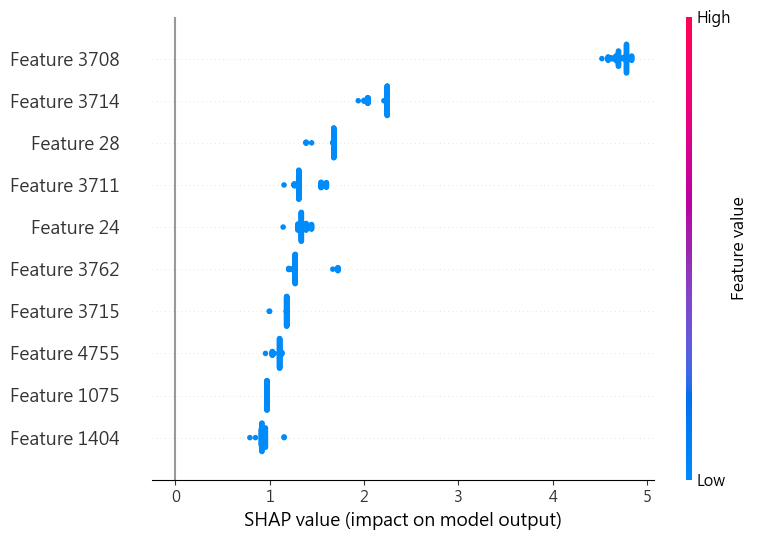

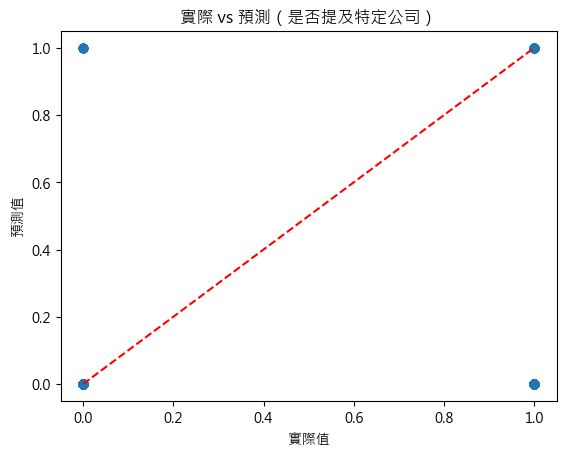

In [10]:
# 完整優化版：TF-IDF + XGBoost + SHAP + 特徵工程 + 自訂參數調整 + 模型儲存
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import matplotlib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack

# 解決中文亂碼
matplotlib.rcParams['font.family'] = 'Microsoft JhengHei'

# 載入資料
mobile_df = pd.read_csv("mobile01_處理後.csv")
ptt_df = pd.read_csv("ptt_語料_處理後.csv")

# 加上平台欄位與統整文字
mobile_df['平台'] = 'Mobile01'
ptt_df['平台'] = 'PTT'
mobile_df['text'] = mobile_df['留言內容'].fillna('') + ' ' + mobile_df['發文內容'].fillna('')
ptt_df['text'] = ptt_df['留言內容'].fillna('') + ' ' + ptt_df['發文內容'].fillna('')

# 合併資料
combined_df = pd.concat([
    mobile_df[['平台', 'text', '詐騙關鍵詞次數', '保險關鍵詞次數', '是否主文', '是否提及特定公司']],
    ptt_df[['平台', 'text', '詐騙關鍵詞次數', '保險關鍵詞次數', '是否主文', '是否提及特定公司']]
], ignore_index=True)

# 加入進階特徵
combined_df['文字長度'] = combined_df['text'].apply(len)
combined_df['關鍵詞總數'] = combined_df['詐騙關鍵詞次數'] + combined_df['保險關鍵詞次數']
combined_df['是否主文'] = combined_df['是否主文'].astype(int)
le = LabelEncoder()
combined_df['平台編碼'] = le.fit_transform(combined_df['平台'])

# 特徵處理
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(combined_df['text'].astype(str))
X_other = combined_df[['詐騙關鍵詞次數', '保險關鍵詞次數', '是否主文', '文字長度', '關鍵詞總數', '平台編碼']].reset_index(drop=True)
X = hstack([X_text, X_other])
y = combined_df['是否提及特定公司'].astype(int)

# 分割資料
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 手動參數組合測試
param_grid = [
    {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.9},
    {'max_depth': 6, 'learning_rate': 0.05, 'n_estimators': 200, 'subsample': 1.0},
    {'max_depth': 3, 'learning_rate': 0.2, 'n_estimators': 150, 'subsample': 0.8},
]

best_f1 = 0
best_model = None

for params in param_grid:
    print(f"測試參數: {params}")
    model = XGBClassifier(eval_metric='logloss', **params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    f1 = report['1']['f1-score']
    print(f"F1-score (label=1): {f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_model = model

# 預測與評估
final_pred = best_model.predict(X_test)
print("最佳模型評估:")
print(classification_report(y_test, final_pred))
print(f'MAE: {mean_absolute_error(y_test, final_pred)}')
print(f'MSE: {mean_squared_error(y_test, final_pred)}')
print(f'R^2: {r2_score(y_test, final_pred)}')

# SHAP 解釋
X_sample = X_test[:100].toarray()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_sample)
shap.summary_plot(shap_values, X_sample, max_display=10)

# 模型儲存
joblib.dump(best_model, "xgb_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

# 視覺化
plt.scatter(y_test, final_pred)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('實際值')
plt.ylabel('預測值')
plt.title('實際 vs 預測（是否提及特定公司）')
plt.show()

c:\Users\Robby1206\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:15:30] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.58      0.43      0.50      4332
           1       0.76      0.85      0.80      9097

    accuracy                           0.72     13429
   macro avg       0.67      0.64      0.65     13429
weighted avg       0.70      0.72      0.70     13429

MAE: 0.28267182962245885
MSE: 0.28267182962245885
R^2: -0.29355004353915737


c:\Users\Robby1206\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  pl.tight_layout()
c:\Users\Robby1206\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


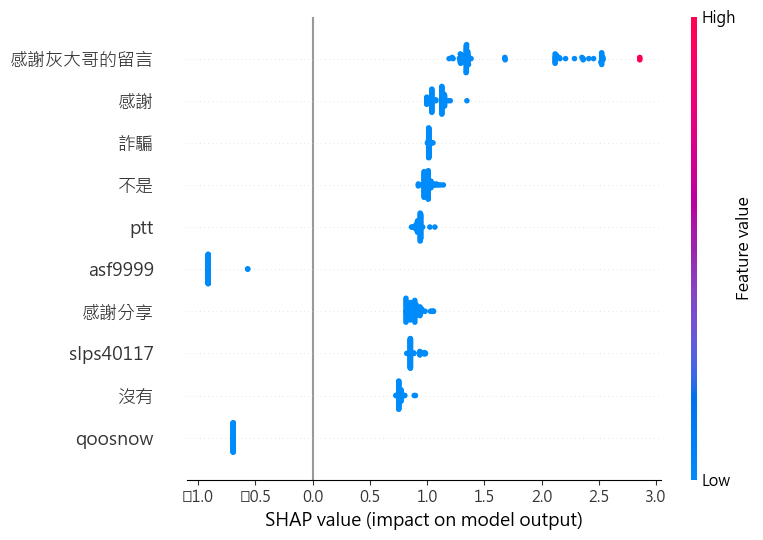

疑似詐騙帳號排行:
                 帳號  預測次數
2006       tourcura   882
3849           灰灰太狼   485
3949  連人帶車100KG還騎超快   356
1673       pigstand   355
2552         我就是愛拍照   220
725            cafm   200
293     LKKSPP16888   132
3996            龍校長   121
486     a0918116005    87
3867           生活玩咖    78


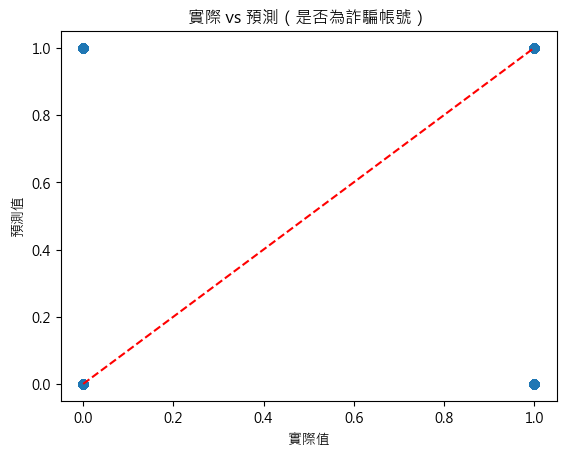

In [14]:
# 檢測帳號是否為詐騙者：以帳號 + 發文內容/留言內容為基礎進行 XGBoost 預測（可視化帳號）
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import matplotlib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack, csr_matrix

# 解決中文亂碼
matplotlib.rcParams['font.family'] = 'Microsoft JhengHei'

# 載入資料
mobile_df = pd.read_csv("mobile01_處理後.csv")
ptt_df = pd.read_csv("ptt_語料_處理後.csv")

# 整合帳號與文字內容
mobile_df['平台'] = 'Mobile01'
ptt_df['平台'] = 'PTT'
mobile_df['帳號'] = mobile_df['留言帳號'].fillna(mobile_df['發文者帳號'])
ptt_df['帳號'] = ptt_df['留言帳號'].fillna(ptt_df['發文者帳號'])
mobile_df['text'] = mobile_df['留言內容'].fillna('') + ' ' + mobile_df['發文內容'].fillna('')
ptt_df['text'] = ptt_df['留言內容'].fillna('') + ' ' + ptt_df['發文內容'].fillna('')

# 合併資料
combined_df = pd.concat([
    mobile_df[['帳號', 'text', '詐騙關鍵詞次數']],
    ptt_df[['帳號', 'text', '詐騙關鍵詞次數']]
], ignore_index=True)

# 清理與標籤
combined_df = combined_df.dropna(subset=['帳號'])
combined_df = combined_df[combined_df['text'].str.strip() != '']
combined_df['label'] = (combined_df['詐騙關鍵詞次數'] > 0).astype(int)

# 特徵轉換
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(combined_df['text'].astype(str))
le_account = LabelEncoder()
account_encoded = le_account.fit_transform(combined_df['帳號'])
X_account = account_encoded.reshape(-1, 1)
X = hstack([X_text, csr_matrix(X_account)])
y = combined_df['label']

# 分割資料
X_train, X_test, y_train, y_test, acc_train, acc_test = train_test_split(X, y, account_encoded, test_size=0.2, random_state=42)

# 使用 XGBoost 模型
model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 評估
print(classification_report(y_test, y_pred))
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'R^2: {r2_score(y_test, y_pred)}')

# SHAP 解釋
X_sample = X_test[:100].toarray()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)
all_feature_names = vectorizer.get_feature_names_out().tolist() + ['帳號編碼']
shap.summary_plot(shap_values, features=X_sample, feature_names=all_feature_names, max_display=10)

# 顯示高風險帳號預測結果
suspicious_accounts = le_account.inverse_transform(acc_test[y_pred == 1])
unique, counts = np.unique(suspicious_accounts, return_counts=True)
account_risk_df = pd.DataFrame({'帳號': unique, '預測次數': counts}).sort_values(by='預測次數', ascending=False)
print("疑似詐騙帳號排行:")
print(account_risk_df.head(10))

# 儲存
joblib.dump(model, "xgb_scam_account_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer_account.pkl")
joblib.dump(le_account, "account_encoder.pkl")

# 散點圖視覺化
plt.scatter(y_test, y_pred)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('實際值')
plt.ylabel('預測值')
plt.title('實際 vs 預測（是否為詐騙帳號）')
plt.show()


c:\Users\Robby1206\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:51:25] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.58      0.43      0.49      4372
           1       0.76      0.85      0.80      9120

    accuracy                           0.72     13492
   macro avg       0.67      0.64      0.65     13492
weighted avg       0.70      0.72      0.70     13492

MAE: 0.2843166320782686
MSE: 0.2843166320782686
R^2: -0.29801568193126915


c:\Users\Robby1206\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  pl.tight_layout()
c:\Users\Robby1206\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


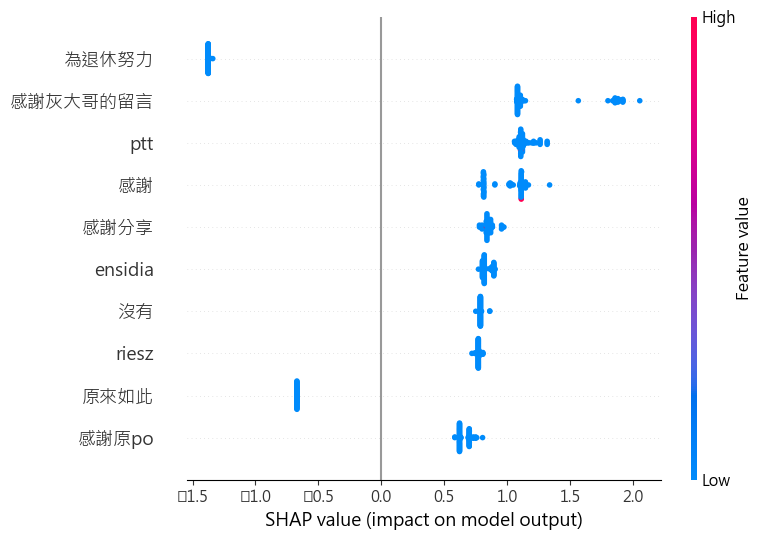

疑似詐騙帳號排行:
                       論壇-帳號  預測次數
695        Mobile01-tourcura   880
1001           Mobile01-灰灰太狼   487
585        Mobile01-pigstand   349
1111  Mobile01-連人帶車100KG還騎超快   320
932          Mobile01-我就是愛拍照   213
288            Mobile01-cafm   204
134     Mobile01-LKKSPP16888   140
1164            Mobile01-龍校長   134
206     Mobile01-a0918116005    88
1021           Mobile01-生活玩咖    83


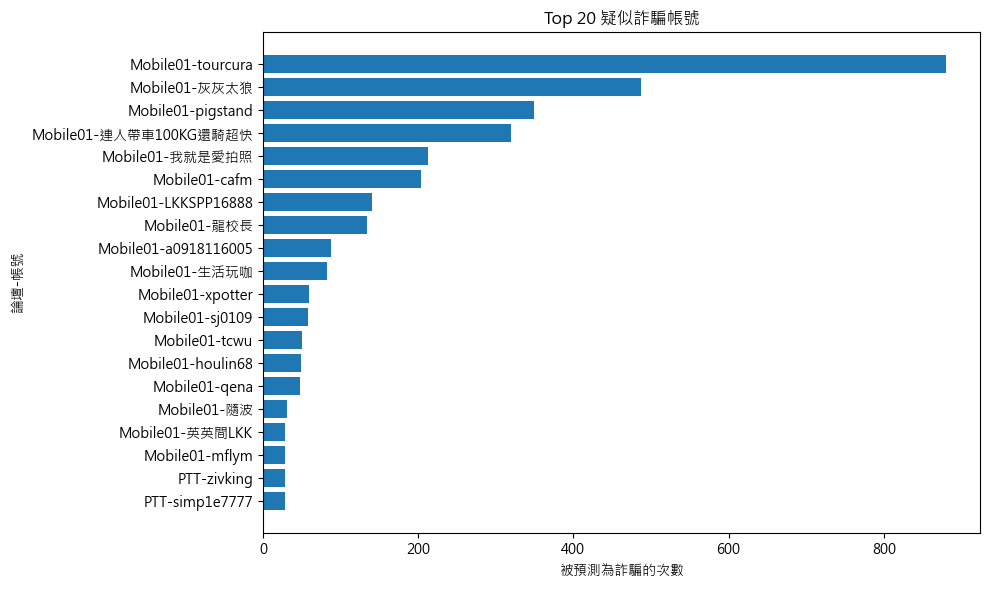

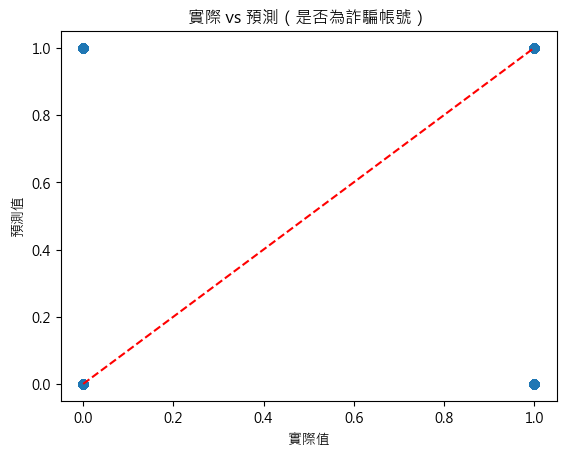

In [33]:
# 檢測帳號是否為詐騙者：以帳號 + 發文內容/留言內容為基礎進行 XGBoost 預測（可視化帳號）
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import matplotlib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack, csr_matrix

# 解決中文亂碼
matplotlib.rcParams['font.family'] = 'Microsoft JhengHei'

# 載入資料
mobile_df = pd.read_csv("mobile01_處理後.csv")
ptt_df = pd.read_csv("ptt_語料_處理後.csv")
finfo_df = pd.read_csv("finfo_posts_產險_壽險_投資型.csv")

# 整合帳號與文字內容
mobile_df['平台'] = 'Mobile01'
ptt_df['平台'] = 'PTT'
finfo_df['平台'] = 'Finfo'

for df in [mobile_df, ptt_df, finfo_df]:
    if '留言帳號' in df.columns and '發文者帳號' in df.columns:
        df['帳號'] = df['留言帳號'].fillna(df['發文者帳號'])
    elif '帳號' in df.columns:
        df['帳號'] = df['帳號']
    elif 'author' in df.columns:
        df['帳號'] = df['author']
    else:
        df['帳號'] = '未知帳號'

    df['留言內容'] = df['留言內容'] if '留言內容' in df.columns else ''
    df['發文內容'] = df['發文內容'] if '發文內容' in df.columns else ''
    df['text'] = df['留言內容'].fillna('') + ' ' + df['發文內容'].fillna('')

    if '詐騙關鍵詞次數' not in df.columns:
        df['詐騙關鍵詞次數'] = 0

# 合併資料
combined_df = pd.concat([
    mobile_df[['平台', '帳號', 'text', '詐騙關鍵詞次數']],
    ptt_df[['平台', '帳號', 'text', '詐騙關鍵詞次數']],
    finfo_df[['平台', '帳號', 'text', '詐騙關鍵詞次數']]
], ignore_index=True)

# 清理與標籤
combined_df = combined_df.dropna(subset=['帳號'])
combined_df = combined_df[combined_df['text'].str.strip() != '']
combined_df['label'] = (combined_df['詐騙關鍵詞次數'] > 0).astype(int)

# 特徵轉換
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(combined_df['text'].astype(str))
le_account = LabelEncoder()
account_encoded = le_account.fit_transform(combined_df['帳號'])
X_account = account_encoded.reshape(-1, 1)
X = hstack([X_text, csr_matrix(X_account)])
y = combined_df['label']

# 分割資料
X_train, X_test, y_train, y_test, acc_train, acc_test, platform_train, platform_test = train_test_split(
    X, y, account_encoded, combined_df['平台'].values, test_size=0.2, random_state=42)

# 使用 XGBoost 模型
model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 評估
print(classification_report(y_test, y_pred))
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'R^2: {r2_score(y_test, y_pred)}')

# SHAP 解釋
X_sample = X_test[:100].toarray()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)
all_feature_names = vectorizer.get_feature_names_out().tolist() + ['帳號編碼']
shap.summary_plot(shap_values, features=X_sample, feature_names=all_feature_names, max_display=10)

# 顯示高風險帳號預測結果（含平台）
suspicious_accounts = le_account.inverse_transform(acc_test[y_pred == 1])
suspicious_platforms = platform_test[y_pred == 1]
account_platform_combo = [f"{p}-{a}" for p, a in zip(suspicious_platforms, suspicious_accounts)]
unique, counts = np.unique(account_platform_combo, return_counts=True)
account_risk_df = pd.DataFrame({'論壇-帳號': unique, '預測次數': counts}).sort_values(by='預測次數', ascending=False)
print("疑似詐騙帳號排行:")
print(account_risk_df.head(10))

# 長條圖視覺化（加上平台）
top_n = 20
top_accounts = account_risk_df.head(top_n)
plt.figure(figsize=(10, 6))
plt.barh(top_accounts['論壇-帳號'], top_accounts['預測次數'])
plt.xlabel('被預測為詐騙的次數')
plt.ylabel('論壇-帳號')
plt.title(f'Top {top_n} 疑似詐騙帳號')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 儲存
joblib.dump(model, "xgb_scam_account_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer_account.pkl")
joblib.dump(le_account, "account_encoder.pkl")

# 散點圖
plt.scatter(y_test, y_pred)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('實際值')
plt.ylabel('預測值')
plt.title('實際 vs 預測（是否為詐騙帳號）')
plt.show()

In [ ]:
# 你提到的 R² = -0.29 的確偏低，但這是因為 R² 不適合用來評估分類任務（像這個「是否為詐騙帳號」是二元分類）。來簡單解析一下：

# 📌 為什麼 R² 在這裡不準？
# R² 是回歸用的指標，用來衡量「模型預測值」與「實際連續數值」的偏差。

# 你現在是分類問題，y 是 0 或 1，而不是連續數值。

# 所以這邊 R² < 0 只是代表「拿它來分類任務是錯誤使用」。

# ✅ 正確的分類評估指標
# Accuracy：整體正確率 → 72%（不錯）

# Recall (class=1)：抓出詐騙的比率 → 85%（很好）

# Precision (class=1)：你抓到的有多少是真的 → 76%（不錯）

# F1-score：精準與召回的綜合 → 0.80（很實用）

# 🎯 什麼時候 R² 才會重要？
# 當你做的任務是：

# 預測價格、分數、使用時間等「連續數值」

# 才適合看 MAE, MSE, R²

# ✅ 建議
# 你可以直接刪除 R² 的 print 行，只留下 classification_report 就夠用了。 要我幫你修改程式，把不必要的指標移除嗎？或者要加上 AUC（更適合詐騙檢測）？

In [ ]:
# SHAP 值總和排名（前 30 特徵）
mean_shap = np.abs(shap_values).mean(axis=0)
top_indices = np.argsort(mean_shap)[::-1][:30]
top_features = [(all_feature_names[i], mean_shap[i]) for i in top_indices]
df_top_features = pd.DataFrame(top_features, columns=["特徵", "平均 SHAP 值"])
print("重要特徵排名（根據 SHAP）:")
print(df_top_features)

重要特徵排名（根據 SHAP）:
               特徵  平均 SHAP 值
0        感謝灰大哥的留言   1.711383
1              感謝   1.097168
2              詐騙   1.015389
3              不是   1.008077
4             ptt   0.927583
5         asf9999   0.904013
6            感謝分享   0.883132
7       slps40117   0.871569
8              沒有   0.762287
9         qoosnow   0.692985
10             恕刪   0.680342
11      dopeyaeen   0.655244
12             投資   0.633041
13       zzzzaaaa   0.606612
14      chenjunfa   0.538419
15        我知道你還有錢   0.535620
16       omega162   0.534291
17  jiangbruce888   0.529553
18          感謝原po   0.520462
19          投資初學者   0.515634
20             ps   0.499327
21            用不到   0.493388
22             30   0.473251
23      redbeanss   0.441744
24             金融   0.441326
25             不會   0.437159
26          xlove   0.436548
27             定存   0.434727
28         nlevta   0.413249
29         投資理財新手   0.386585


In [5]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [36]:
pip install lightGBM


  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [12]:
print(merged_df.columns.tolist())

['帳號', '帳號出現次數', '是否凌晨', '是否含詐騙字詞', '內容長度', '是否主文', '來源_ptt-gossiping-回文', '來源_ptt-insurance-回文', '來源_ptt-lifeismoney-回文', '來源_ptt-stock-回文', '來源_ptt-womentalk-回文', 'isolation_anomaly_score', 'svm_anomaly_score', '00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '101', '106', '11', '111', '112', '114', '116', '118', '12', '123', '125', '13', '136', '137', '138', '139', '14', '140', '15', '16', '160', '163', '17', '18', '180', '19', '20', '200', '21', '215', '216', '217', '218', '22', '220', '223', '227', '228', '23', '231', '24', '240', '242', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '61', '64', '71', '72', '73', '77', '78', '79', '82', '謝謝', '謝謝分享']
